# Part 1: Exploratory Analysis & Baseline Features

## Outline
1. Retrieve Data
2. Investiagte Class Imbalance
3. Theories for Good Potential Features
4. Univariate Analysis and Feature Engineering
5. Generate Baseline Dataset with useful, non-graph, features

In [1]:
%%capture
%pip install python-dotenv google-cloud-storage scikit-learn matplotlib

In [2]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from google.cloud import storage

## Retrieve Data

In [3]:
provider_df = pd.read_csv('gs://neo4j-insurance-claim-tutorial-data/provider.csv')
provider_df

,provider,potentialFraud,potentialFraudInd
0,PRV51001,No,0
1,PRV51003,Yes,1
2,PRV51004,No,0
3,PRV51005,Yes,1
4,PRV51007,No,0
...,...,...,...
5405,PRV57759,No,0
5406,PRV57760,No,0
5407,PRV57761,No,0
5408,PRV57762,No,0


In [4]:
claim_df = pd.read_csv('gs://neo4j-insurance-claim-tutorial-data/claim.csv', low_memory=False)
claim_df

,beneID,claimID,claimStartDt,claimEndDt,provider,inscClaimAmtReimbursed,attendingPhysician,operatingPhysician,otherPhysician,admissionDt,...,chronicCondrheumatoidarthritis,chronicCondstroke,iPAnnualReimbursementAmt,iPAnnualDeductibleAmt,oPAnnualReimbursementAmt,oPAnnualDeductibleAmt,dobYear,isDeceased,maxDate,approxAge
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,1,1,36000,3204,60,70,1943,0,2009-12-01,67.0
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,1,1,36000,3204,60,70,1943,0,2009-12-01,67.0
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,1,1,36000,3204,60,70,1943,0,2009-12-01,67.0
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,1,1,5000,1068,250,320,1914,0,2009-12-01,95.8
4,BENE11011,CLM144521,2009-01-18,2009-01-18,PRV52314,50,PHY379398,NaN,NaN,NaN,...,1,1,5000,1068,250,320,1914,0,2009-12-01,95.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,BENE159198,CLM510792,2009-08-06,2009-08-06,PRV53699,800,PHY364188,PHY364188,PHY385752,NaN,...,1,0,0,0,5470,1870,1952,0,2009-12-01,57.7
558207,BENE159198,CLM551294,2009-08-29,2009-08-29,PRV53702,400,PHY423019,PHY332284,NaN,NaN,...,1,0,0,0,5470,1870,1952,0,2009-12-01,57.7
558208,BENE159198,CLM596444,2009-09-24,2009-09-24,PRV53676,60,PHY361063,NaN,NaN,NaN,...,1,0,0,0,5470,1870,1952,0,2009-12-01,57.7
558209,BENE159198,CLM636992,2009-10-18,2009-10-18,PRV53689,70,PHY403198,NaN,PHY419379,NaN,...,1,0,0,0,5470,1870,1952,0,2009-12-01,57.7


## Investiage Class imbalance
As a first step let us examine class imbalance.  In most fraud problems we expect a highly imbalanced dataset with an extremly small number of fraud observations relative to others

In [5]:
provider_df.potentialFraudInd.mean()
print(f'About {provider_df.potentialFraudInd.mean():.2%} of providers are marked as potential fraud.')

About 9.35% of providers are marked as potential fraud.


In [6]:
#create a combined dataset to make EDA easier
df = claim_df.merge(provider_df, on='provider')
print(f'About {df.potentialFraudInd.mean():.2%} of claims are made by potential fraud providers.')

About 38.12% of claims are made by potential fraud providers.


The above numbers seem high. It is hard to concieve that 38.12% of provider claims in the United States are fraudulant.  This suggests that either
1. This dataset reflects a narrowed down subset of providers and/or claims. Ones that were previously flagged as suspicious. 
2. The labeling is intended for a flagging system further upstream to be followed by other methods for narrowing down on truely fraudulent providers. 

Either way it should be okay for our intents and purposes.  We can create an ML model for this stage in a fraud detection system either way.  

Ultimatly, There is some class imbalance here, but it isn't extreme.  This means that we may need to rebalance or reweight for model training, but it may not be completly necessary and we will probably not be faced with extreme challenges here as is often the case with other fraudf detection problems. 


One thing to note is that the above numbers suggest fraudulant providers create more claims, on average, than non-fraudulent ones. 

## Theories (based off of features easy to aggregate in a table)
There are a lot of different ways we could go here.  Here are some recommendations based off other analysis on Kaggle. 

Where is medical provider fraud more liklely to happen?
1. Is provider fraud concentrated in certain patient demographics: race/gender?
2. Does it vary based on patient conditions? - fraud may be more common in certain medical practices or for treatment of certain chronic conditions or desease.

Things that may be indicators of medical provider fraud
1. High number of claims
2. Lack of physician presence on the claim

## Univariate Analysis and Feature Engineering

### Patient Demographics - Race & Gender?
For this we really just want to see if there are drastically different distributions between fraud and non-fraud claims. To avoid problamtic biases, we want to be very cautious before including features like these in an AutoML ML.

In [7]:
# Get totals claims race and fraud indicator
agg_df = df[['provider', 'potentialFraudInd','race']].groupby(['potentialFraudInd', 'race']).count().reset_index().pivot(columns='potentialFraudInd', index='race', values='provider')
agg_df

potentialFraudInd,0,1
race,,
1,292691,178345
2,35356,20284
3,10753,8962
5,6615,5205


In [8]:
# devide by totals to get percentages
agg_df[0] = agg_df[0]/sum(agg_df[0])
agg_df[1] = agg_df[1]/sum(agg_df[1])
agg_df

potentialFraudInd,0,1
race,,
1,0.847360,0.838103
2,0.102358,0.095321
3,0.031131,0.042115
5,0.019151,0.024460


There doesn't seem to be a major difference in distribution.  Lets also look at gender

In [9]:
agg_df = df[['provider', 'potentialFraudInd','gender']].groupby(['potentialFraudInd', 'gender']).count().reset_index().pivot(columns='potentialFraudInd', index='gender', values='provider')
agg_df[0] = agg_df[0]/sum(agg_df[0])
agg_df[1] = agg_df[1]/sum(agg_df[1])
agg_df

potentialFraudInd,0,1
gender,,
1,0.420983,0.421451
2,0.579017,0.578549


again extremly similar.  We can also look at both simultaniously to see if a multi-variate analysis would yield any doifferences. 

In [10]:
agg_df = df[['provider', 'potentialFraudInd','gender', 'race']].groupby(['potentialFraudInd', 'gender', 'race']).count().reset_index().pivot(columns='potentialFraudInd', index=['gender', 'race'], values='provider')
agg_df[0] = agg_df[0]/sum(agg_df[0])
agg_df[1] = agg_df[1]/sum(agg_df[1])
agg_df

potentialFraudInd         0         1
gender race                          
1      1           0.358337  0.355744
       2           0.040499  0.036796
       3           0.013740  0.018783
       5           0.008407  0.010127
2      1           0.489023  0.482359
       2           0.061859  0.058526
       3           0.017391  0.023332
       5           0.010744  0.014333

Again we see a similer story with little difference.  We should probably be fine to leave these variable out with little impact to AutoML. 

### Patient Conditions? 
Ty fraud may be more common in certain medical practices or for treatment of certain chronic conditions or desease. 

In [11]:
# Combine into condition encoding vector
condition_cols = ['renalDiseaseIndicator'] + [col for col in df.columns if 'chronicCond' in col]
df['conditions'] = df[condition_cols].values.tolist()
df.conditions = df.conditions.apply(np.array)
df[['conditions'] + condition_cols]

,conditions,renalDiseaseIndicator,chronicCondAlzheimer,chronicCondHeartfailure,chronicCondKidneyDisease,chronicCondCancer,chronicCondObstrPulmonary,chronicCondDepression,chronicCondDiabetes,chronicCondIschemicHeart,chronicCondOsteoporasis,chronicCondrheumatoidarthritis,chronicCondstroke
0,"[0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1]",0,1,0,1,0,0,1,1,1,0,1,1
1,"[0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]",0,1,1,1,0,0,0,0,1,0,0,0
2,"[0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0]",0,1,1,1,0,1,0,0,1,0,0,0
3,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]",0,0,0,0,0,0,0,0,1,1,0,0
4,"[0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0]",0,0,1,0,0,1,0,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]",0,0,0,0,0,0,0,0,1,1,0,0
558207,"[0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0]",0,1,0,1,0,0,0,1,1,0,1,0
558208,"[1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0]",1,1,1,1,0,1,0,1,1,0,0,0
558209,"[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]",0,0,1,1,1,1,1,1,1,1,1,0


In [12]:
## aggregate to provider level
def normalize_sum(x):
    res = sum(x)
    d = sum(res)
    if d > 0:
        res = res/d
    return res
        
    return res/res.sum()

agg_df = (df[['provider', 'potentialFraudInd', 'conditions']].groupby(['provider', 'potentialFraudInd'])
               .agg({'conditions':normalize_sum}).reset_index())

In [13]:
# instantiate the TSNE model
tsne = TSNE(n_components=2, random_state=7474, init='random', learning_rate="auto")
# Use the TSNE model to fit and output a 2-d representation
E = tsne.fit_transform(np.stack(agg_df['conditions'], axis=0))

In [14]:
coord_df = pd.concat([agg_df, pd.DataFrame(E, columns=['x', 'y'])], axis=1)
coord_df

,provider,potentialFraudInd,conditions,x,y
0,PRV51001,0,"[0.05442176870748299, 0.10204081632653061, 0.1...",-40.328506,-32.901894
1,PRV51003,1,"[0.046104928457869634, 0.0890302066772655, 0.1...",-39.464283,22.555281
2,PRV51004,0,"[0.034328358208955224, 0.0955223880597015, 0.1...",12.099857,19.402557
3,PRV51005,1,"[0.0487758945386064, 0.08022598870056497, 0.12...",-14.725824,6.680757
4,PRV51007,0,"[0.03536977491961415, 0.08360128617363344, 0.1...",2.234295,6.936782
...,...,...,...,...,...
5405,PRV57759,0,"[0.03289473684210526, 0.09210526315789473, 0.1...",-39.399845,15.138844
5406,PRV57760,0,"[0.0, 0.03896103896103896, 0.14285714285714285...",0.497353,56.617016
5407,PRV57761,0,"[0.05476190476190476, 0.08571428571428572, 0.1...",-16.116156,-27.297327
5408,PRV57762,0,"[0.0, 0.0, 0.0, 0.2, 0.2, 0.2, 0.0, 0.2, 0.2, ...",-37.400940,57.483521


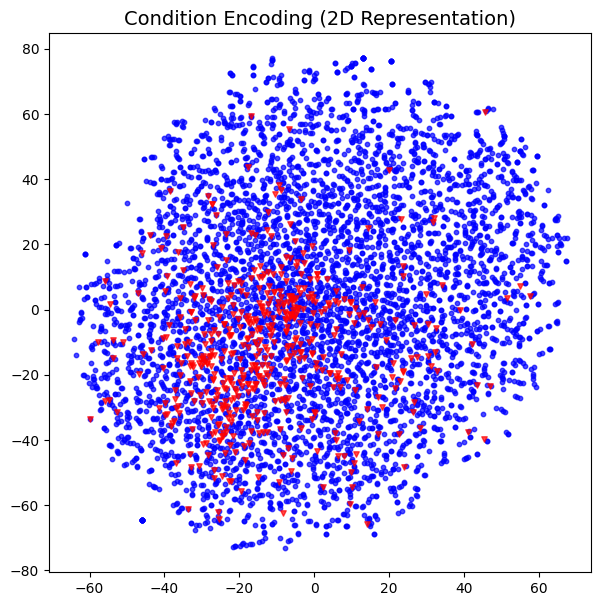

In [15]:
plt.rcParams["figure.figsize"] = (7,7)
plt.title('Condition Encoding (2D Representation)', fontsize=14)
plt.scatter(coord_df[coord_df.potentialFraudInd==0].x, 
            coord_df[coord_df.potentialFraudInd==0].y, 
            s=10, 
            marker='o', 
            c='#0000FF', 
            alpha=0.7)

plt.scatter(coord_df[coord_df.potentialFraudInd==1].x, 
            coord_df[coord_df.potentialFraudInd==1].y, 
            s=15, 
            marker='v', 
            c='#FF0000', 
            alpha=0.7)

While it may not be strong, there does seem to be a pattern here. You can see the tighter red clustering.  Lets include the condtion encoding as a feature. 

In [16]:
# break out condition enc into  seperate columns
agg_df[[col + 'Enc' for col in condition_cols]] = agg_df.conditions.tolist()

In [18]:
# We will save this dataframe to a dictionary and comnine all the features together at the end of the notebook. 
feature_dfs = {}
feature_dfs['conditionEnc'] = agg_df.drop(columns = ['conditions', 'potentialFraudInd'])
feature_dfs['conditionEnc']

,provider,renalDiseaseIndicatorEnc,chronicCondAlzheimerEnc,chronicCondHeartfailureEnc,chronicCondKidneyDiseaseEnc,chronicCondCancerEnc,chronicCondObstrPulmonaryEnc,chronicCondDepressionEnc,chronicCondDiabetesEnc,chronicCondIschemicHeartEnc,chronicCondOsteoporasisEnc,chronicCondrheumatoidarthritisEnc,chronicCondstrokeEnc
0,PRV51001,0.054422,0.102041,0.129252,0.115646,0.034014,0.068027,0.061224,0.142857,0.156463,0.040816,0.054422,0.040816
1,PRV51003,0.046105,0.089030,0.127186,0.101749,0.015898,0.065183,0.085851,0.158983,0.178060,0.052464,0.060413,0.019078
2,PRV51004,0.034328,0.095522,0.131343,0.074627,0.023881,0.061194,0.094030,0.156716,0.161194,0.073134,0.068657,0.025373
3,PRV51005,0.048776,0.080226,0.128060,0.095480,0.031073,0.055556,0.091337,0.150471,0.168550,0.064783,0.062335,0.023352
4,PRV51007,0.035370,0.083601,0.128617,0.070740,0.038585,0.051447,0.093248,0.157556,0.163987,0.067524,0.070740,0.038585
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,0.032895,0.092105,0.131579,0.098684,0.026316,0.072368,0.059211,0.131579,0.184211,0.085526,0.059211,0.026316
5406,PRV57760,0.000000,0.038961,0.142857,0.025974,0.000000,0.025974,0.090909,0.233766,0.285714,0.142857,0.012987,0.000000
5407,PRV57761,0.054762,0.085714,0.133333,0.095238,0.033333,0.071429,0.090476,0.130952,0.147619,0.076190,0.057143,0.023810
5408,PRV57762,0.000000,0.000000,0.000000,0.200000,0.200000,0.200000,0.000000,0.200000,0.200000,0.000000,0.000000,0.000000


### High Number of Claims

Text(0.5, 0.98, 'Claim Count by Fraud Indicator')

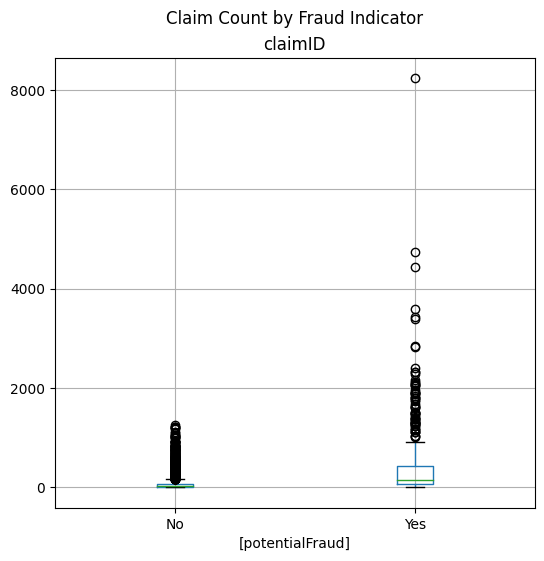

In [19]:
plt.rcParams["figure.figsize"] = (6,6)
agg_df = df[['provider','potentialFraud', 'claimID']].groupby(['provider', 'potentialFraud']).count().reset_index('potentialFraud')
ax = agg_df.boxplot(by='potentialFraud')
ax.get_figure().suptitle('Claim Count by Fraud Indicator')

Text(0.5, 0.98, 'Log Claim Count by Fraud Indicator')

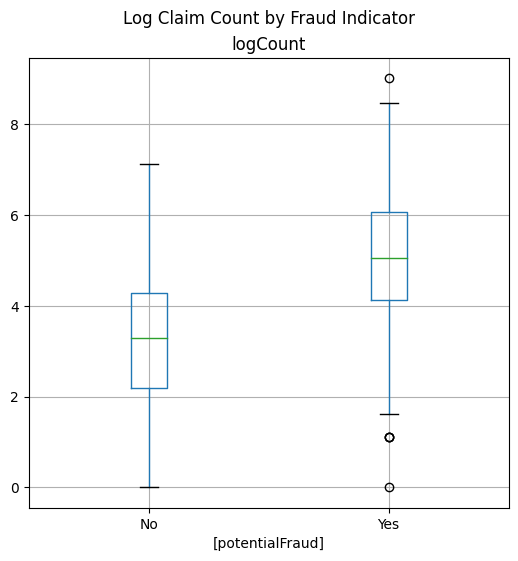

In [20]:
#lets use logs to make it easier to see
agg_df['logCount'] = np.log(agg_df['claimID'])
ax = agg_df[['potentialFraud', 'logCount']].boxplot(by='potentialFraud')
ax.get_figure().suptitle('Log Claim Count by Fraud Indicator')

This seems like a significant difference.  claim count should be included as a feature

In [21]:
feature_dfs['claimCount'] = agg_df.reset_index().drop(columns=['potentialFraud', 'logCount']).rename(columns={'claimID':'claimCount'})
feature_dfs['claimCount']

,provider,claimCount
0,PRV51001,25
1,PRV51003,132
2,PRV51004,149
3,PRV51005,1165
4,PRV51007,72
...,...,...
5405,PRV57759,28
5406,PRV57760,22
5407,PRV57761,82
5408,PRV57762,1


### Lack of Physician Presence on Claim

In [22]:
# Reshape dfs to long on physicians
df = df.rename(columns = {'oprPhysicianInd': 'physicianIndOpr', 'attPhysicianInd': 'physicianIndAtt', 'otherPhysicianInd': 'physicianIndOther'})
phys_cols = [col for col in df.columns if 'physicianInd' in col]
phys_df = pd.wide_to_long(df[phys_cols  + ['claimID', 'provider', 'potentialFraudInd']], stubnames='physicianInd', i='claimID', j='physicianType', suffix='\D+').dropna().reset_index()
phys_df

,claimID,physicianType,provider,potentialFraudInd,physicianInd
0,CLM46614,Opr,PRV55912,1,0
1,CLM565430,Opr,PRV55912,1,1
2,CLM34721,Opr,PRV55912,1,1
3,CLM72336,Opr,PRV55912,1,1
4,CLM73394,Opr,PRV55912,1,1
...,...,...,...,...,...
1674628,CLM394122,Other,PRV54050,0,1
1674629,CLM184358,Other,PRV54302,0,0
1674630,CLM460770,Other,PRV51577,0,0
1674631,CLM306999,Other,PRV53083,0,0


Text(0.5, 0.98, 'Claim Fraction Physician Presence by Fraud Indicator')

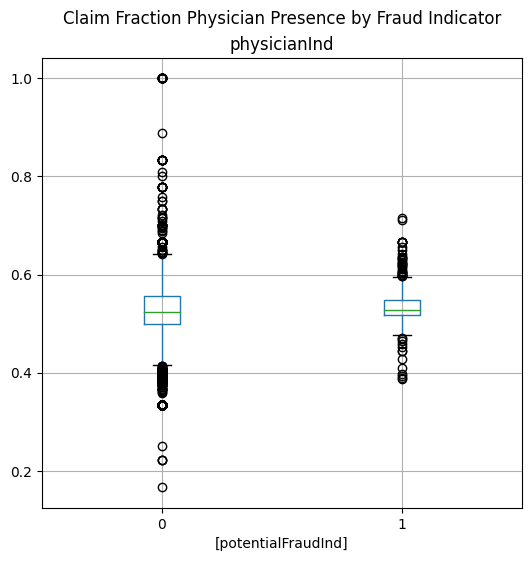

In [23]:
# aggregate to provider level and box plot
agg_df = phys_df[['provider', 'physicianInd', 'potentialFraudInd']] \
    .groupby(['provider', 'potentialFraudInd']).mean().reset_index('potentialFraudInd')

ax = agg_df.boxplot(by='potentialFraudInd')
ax.get_figure().suptitle('Claim Fraction Physician Presence by Fraud Indicator')

This doesn't look to vary much between fraud and non-fraud providers.  Lets not use this as a feature for now.

## Generate Baseline Dataset
We will write locally and to Google Cloud Storage. 

In [24]:
provider_feat_df = provider_df.drop(columns='potentialFraud')
for feature_df in feature_dfs.values():
    provider_feat_df = provider_feat_df.merge(feature_df, on='provider')
provider_feat_df

,provider,potentialFraudInd,renalDiseaseIndicatorEnc,chronicCondAlzheimerEnc,chronicCondHeartfailureEnc,chronicCondKidneyDiseaseEnc,chronicCondCancerEnc,chronicCondObstrPulmonaryEnc,chronicCondDepressionEnc,chronicCondDiabetesEnc,chronicCondIschemicHeartEnc,chronicCondOsteoporasisEnc,chronicCondrheumatoidarthritisEnc,chronicCondstrokeEnc,claimCount
0,PRV51001,0,0.054422,0.102041,0.129252,0.115646,0.034014,0.068027,0.061224,0.142857,0.156463,0.040816,0.054422,0.040816,25
1,PRV51003,1,0.046105,0.089030,0.127186,0.101749,0.015898,0.065183,0.085851,0.158983,0.178060,0.052464,0.060413,0.019078,132
2,PRV51004,0,0.034328,0.095522,0.131343,0.074627,0.023881,0.061194,0.094030,0.156716,0.161194,0.073134,0.068657,0.025373,149
3,PRV51005,1,0.048776,0.080226,0.128060,0.095480,0.031073,0.055556,0.091337,0.150471,0.168550,0.064783,0.062335,0.023352,1165
4,PRV51007,0,0.035370,0.083601,0.128617,0.070740,0.038585,0.051447,0.093248,0.157556,0.163987,0.067524,0.070740,0.038585,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,0,0.032895,0.092105,0.131579,0.098684,0.026316,0.072368,0.059211,0.131579,0.184211,0.085526,0.059211,0.026316,28
5406,PRV57760,0,0.000000,0.038961,0.142857,0.025974,0.000000,0.025974,0.090909,0.233766,0.285714,0.142857,0.012987,0.000000,22
5407,PRV57761,0,0.054762,0.085714,0.133333,0.095238,0.033333,0.071429,0.090476,0.130952,0.147619,0.076190,0.057143,0.023810,82
5408,PRV57762,0,0.000000,0.000000,0.000000,0.200000,0.200000,0.200000,0.000000,0.200000,0.200000,0.000000,0.000000,0.000000,1


Write to csv

In [26]:
provider_feat_df.to_csv('baseline.csv', index=False)

Write to Google Cloud Storage

In [27]:
load_dotenv('config.env', override=True)
REGION = os.getenv('GCLOUD_REGION')
shell_output = ! gcloud config list --format 'value(core.project)' 2>/dev/null
PROJECT_ID = shell_output[0]

STORAGE_BUCKET = PROJECT_ID + '-fsi'
os.environ["GCLOUD_PROJECT"] = PROJECT_ID

In [28]:
client = storage.Client()
bucket = client.bucket(STORAGE_BUCKET)
if not bucket.exists():
    bucket.create(location=REGION)

In [29]:
blob = bucket.blob(os.path.join('insurance_fraud', 'baseline.csv'))
blob.upload_from_filename('baseline.csv')